# YouTube Data API v3

### Python Libraries

In [1]:
import requests
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

import collections

### Imported Scripts

In [29]:
    # api_key is stored in config.py
import config

    # Functions for making youtube_requests
import youtube_requests

    # Functions for data processing
import data_processing

    # Functions for creating a network graph    
import network_graphs

import importlib
importlib.reload(network_graphs)

<module 'network_graphs' from '/Users/DanOvadia/Projects/YoutubeChannels/network_graphs.py'>

In [3]:
%load_ext autoreload

In [4]:
%autoreload 1

In [5]:
%aimport network_graphs
%aimport youtube_requests

# YouTube Channel Details by Search

Returns a details list of channels for a specific search query and number of requested results.

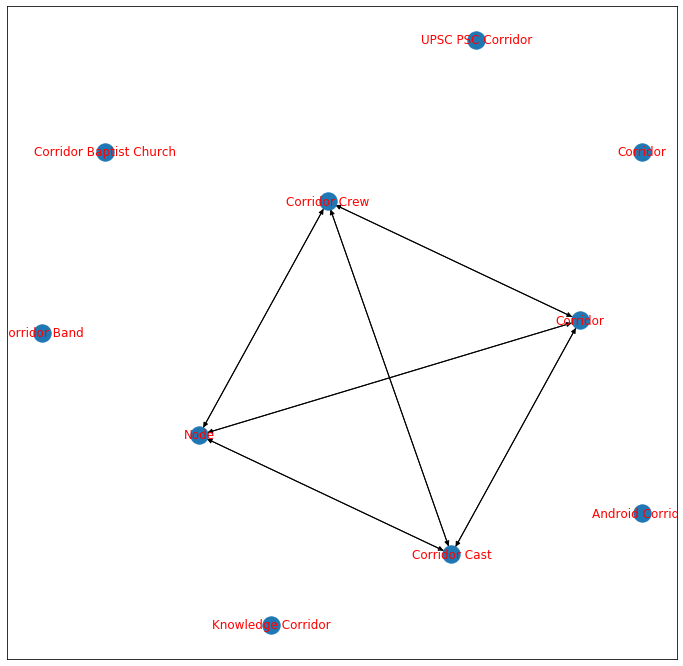

In [7]:
# Get a list of dictionaries, where each dictionary represents details for a specific channel
CHANNELS_DETAILS_ITEMS_LIST = youtube_requests.youtube_channel_details_by_search('Corridor',10)

# Graph the network of channels
G = network_graphs.create_nx_graph(CHANNELS_DETAILS_ITEMS_LIST)

# Extract a columnar list of channel details
CHANNELS_DETAILS_LIST = data_processing.extract_channel_details(CHANNELS_DETAILS_ITEMS_LIST)

# Create a dataframe
DF = data_processing.create_df_from_details_list(CHANNELS_DETAILS_LIST)

# Graph G
network_graphs.graph_nx_graph(G)

# Youtube Channel Details by Network

In [24]:
CORRIDOR_RESP = CHANNELS_DETAILS_ITEMS_LIST[3:5]

In [11]:
[channel['snippet']['title'] for channel in CHANNELS_DETAILS_ITEMS_LIST[0:5]]

['Corridor Cast',
 'Corridor Band',
 'Corridor Baptist Church',
 'Corridor',
 'Corridor Crew']

In [ ]:
[channel['snippet']['title'] for channel in CHANNELS_DETAILS_ITEMS_LIST]

In [19]:
CORRIDOR_RESP[1]['snippet']['title']

IndexError: list index out of range

13 total neighbors; 0 out of 2 channels do not feature channels
66 total neighbors; 1 out of 13 channels do not feature channels


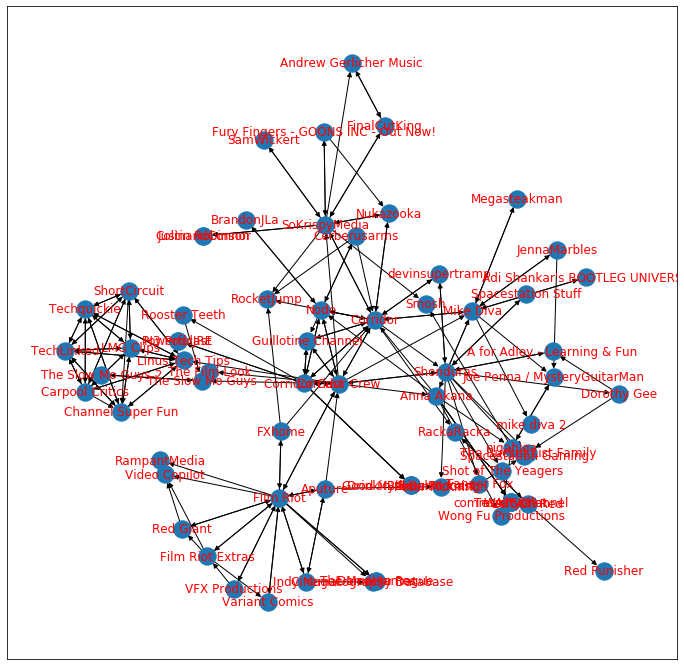

In [31]:
# Get a list of dictionaries, where each dictionary represents details for a specific channel
CHANNELS_DETAILS_ITEMS_LIST = youtube_requests.youtube_channel_details_by_network(CORRIDOR_RESP, 2)

# Graph the network of channels
G = network_graphs.create_nx_graph(CHANNELS_DETAILS_ITEMS_LIST)

# Extract a columnar list of channel details
# CHANNELS_DETAILS_LIST = data_processing.extract_channel_details(CHANNELS_DETAILS_ITEMS_LIST)

# Create a dataframe
#DF = data_processing.create_df_from_details_list(CHANNELS_DETAILS_LIST)

# Graph G
network_graphs.graph_nx_graph(G)

In [ ]:
go.scatter.Marker()

In [44]:
go.Scatter()

Object `go.Scatter()` not found.


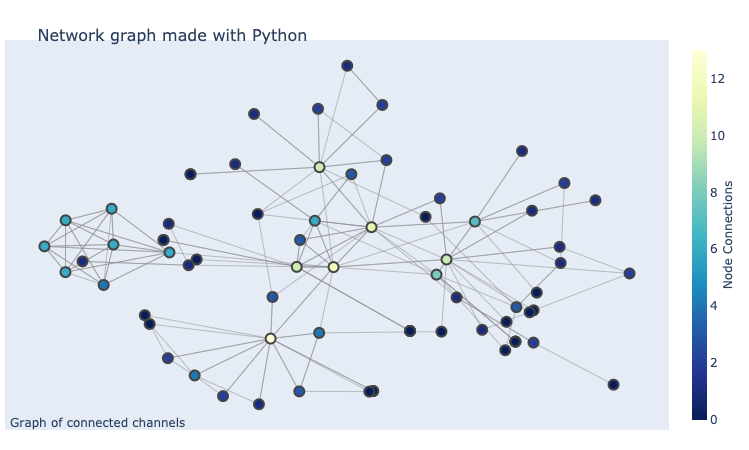

In [42]:
network_graphs.plotly_network_graph(G)

In [37]:
import plotly.graph_objects as go

In [ ]:
go.Scatter()

In [ ]:
go.Figure()
go.Layout()

In [ ]:
for edge in G.edges():
    print(G.nodes[edge[0]])

In [134]:
H.nodes['UChVTBV42Ao5krVgPMz3R9ww']

{'pos': array([ 0.81402831, -0.2404856 ]), 'title': 'Megasteakman'}

In [ ]:
[H.nodes[node]['title'] for node in H.nodes]

In [ ]:
{node:G.nodes()[node] for node in G.nodes()}

In [190]:
{node:H.nodes()[node]['title'] for node in H.nodes()}

{'UChVTBV42Ao5krVgPMz3R9ww': 'Megasteakman',
 'UCSrPuHtKbst7Zy8pyWn_3Cg': "What's Inside?",
 'UC6sokr_zvkvLdhTfJD2QC_w': 'johnyboz',
 'UCzQUP1qoWDoEbmsQxvdjxgQ': 'PowerfulJRE',
 'UCzofNVHFCdD_4Jxs5dVqtAA': 'TEAMSUPERTRAMP',
 'UCyC_4jvPzLiSkJkLIkA7B8g': 'Lindsey Stirling',
 'UCLK5icWTfKgw6I2HIku84vg': "Drinkin' Bros Podcast",
 'UCQqi--mpTFtGNim0WCtPH-A': 'Nukazooka',
 'UCYq-iAOSZBvoUxvfzwKIZWA': 'Jacob + Katie Schwarz',
 'UCSpFnDQr88xCZ80N-X7t0nQ': 'Corridor Crew',
 'UCKo61AAaRD00ibCWJZ321MQ': 'SoKrispyMedia',
 'UCNSeDrWRGxx5p2l3tj7RWQw': 'Corridor Cast',
 'UCOYWgypDktXdb-HfZnSMK6A': 'TomSka',
 'UCAp990eMLzmei84WNR4ptgA': 'Bill Burr',
 'UC7XJ6Oa8IzD7j5sqJLq4Ghg': 'Spacestation Gaming',
 'UCnfeQePP9wc6W9rNUvQVkwA': 'Pyrobot',
 'UCUK0HBIBWgM2c4vsPhkYY4w': 'The Slow Mo Guys',
 'UC60zl3j4jDlwPDy73aKaCtQ': 'Left On Red',
 'UCmLpukyN1nfdEqvg1I97poQ': 'Spacestation Stuff',
 'UCeldJxsHTM9ycdUT4SJsa7Q': 'Atomic Punch',
 'UC3DkFux8Iv-aYnTRWzwaiBA': 'Peter McKinnon',
 'UCY30JRSgfhYXA6i6xX1erWg': '

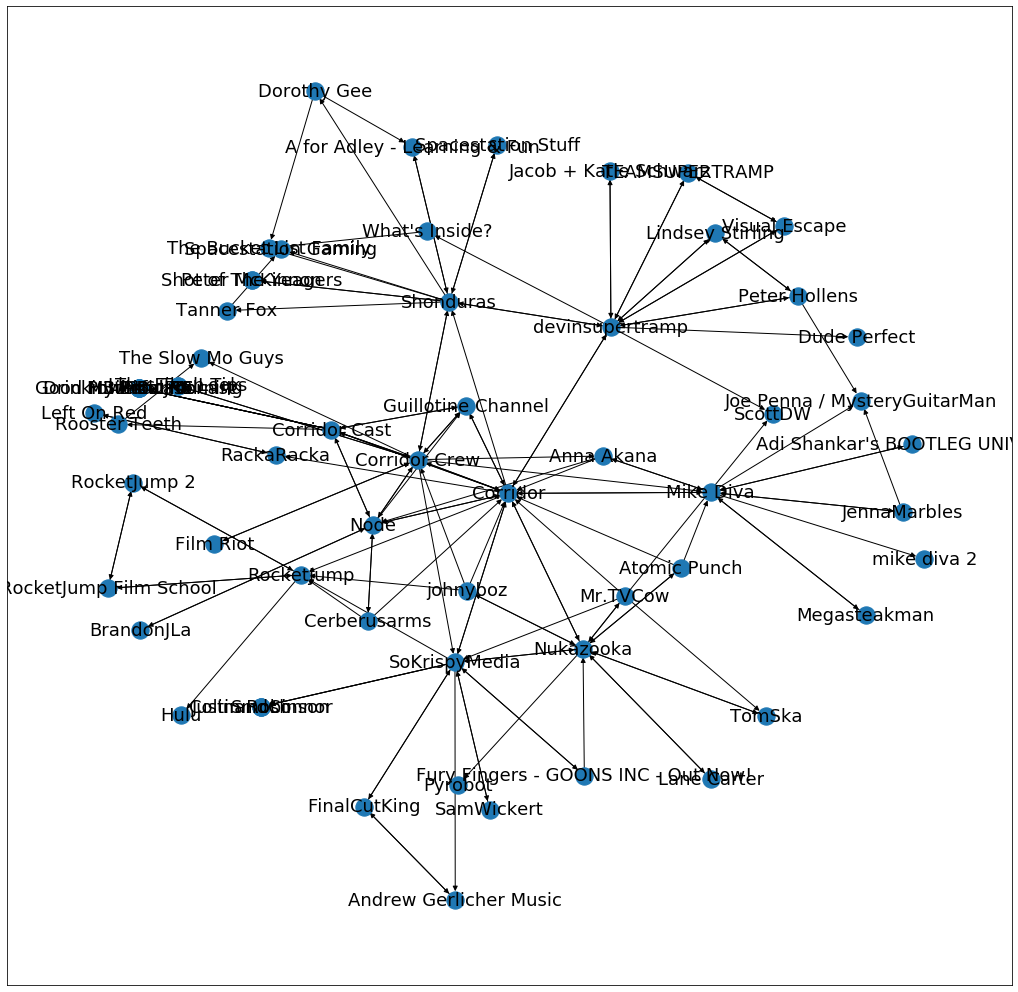

In [163]:
CHANNELS_ID_LIST = [channel['id'] for channel in CHANNELS_DETAILS_ITEMS_LIST]
CHANNEL_NAMES = {channel['id']:channel['snippet']['title'] \
                   if 'title' in channel['snippet'] else [] \
                   for channel in CHANNELS_DETAILS_ITEMS_LIST}

H = G.subgraph(CHANNELS_ID_LIST)
plt.figure(figsize = (18,18))
POS = nx.drawing.layout.kamada_kawai_layout(H)
nx.set_node_attributes(H, POS, name='pos')
nx.set_node_attributes(H, CHANNEL_NAMES, name='title')
nx.draw_networkx(H,
             with_labels=True,
             pos=POS,
             labels=CHANNEL_NAMES,
             font_size=18, font_color = 'k')

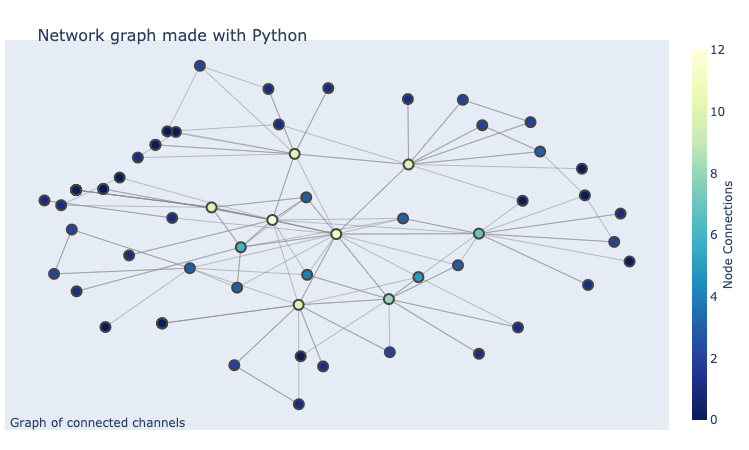

In [172]:
network_graphs.plotly_network_graph(H)

In [18]:
# Get a list of dictionaries, where each dictionary represents details for a specific channel
CHANNELS_DETAILS_ITEMS_LIST = youtube_requests.youtube_channel_details_by_search('Corridor',50)

# Graph the network of channels
G = network_graphs.create_nx_graph(CHANNELS_DETAILS_ITEMS_LIST)

# Extract a columnar list of channel details
CHANNELS_DETAILS_LIST = data_processing.extract_channel_details(CHANNELS_DETAILS_ITEMS_LIST)

# Create a dataframe
DF = data_processing.create_df_from_details_list(CHANNELS_DETAILS_LIST)

features = ['id','title','description','customUrl','publishedAt','country','isLinked', 'viewCount', 'commentCount', 'subscriberCount', 'hiddenSubscriberCount','keywords','showRelatedChannels','featuredChannelsUrls', 'featuredChannelsCount']

In [48]:
PAGE_RANK_VECTOR = network_graphs.simple_page_rank(G)

0.15558966928720647
0.15695594008184363
0.06270442996743884
0.03286073451159962
0.01692671121231505
0.009919196557706143
0.005284857272617792
0.0030379695578857282
0.001626755980805569
0.0009267822482785635
0.0004974141047513391
0.0002820304571672055
0.00015191275278262308
8.600032636397628e-05
4.661125602236717e-05
2.6416476416300127e-05
1.4443730318074682e-05
8.210327308526807e-06
4.536470671761566e-06
2.588929840913161e-06


In [49]:
CHANNELIDS = list(G.nodes().keys())
vector = pd.Series(data = PAGE_RANK_VECTOR, index = CHANNELIDS)

In [52]:
DF['v1'] = DF['id'].map(lambda x:vector[x])

In [53]:
DF[['title','id','subscriberCount','viewCount','v1','featuredChannelsCount']].sort_values('v1', ascending=False).head(20)

,title,id,subscriberCount,viewCount,v1,featuredChannelsCount
0,Corridor,UCsn6cjffsvyOZCZxvGoJxGg,8060000,1463046799,0.101940,11
4,Corridor Crew,UCSpFnDQr88xCZ80N-X7t0nQ,4090000,706000450,0.095757,12
10,Node,UCI4Wh0EQPjGx2jJLjmTsFBQ,3260000,798468842,0.075889,6
1,Corridor Cast,UCNSeDrWRGxx5p2l3tj7RWQw,110000,4989413,0.067070,10
8,Nukazooka,UCQqi--mpTFtGNim0WCtPH-A,2250000,669066458,0.063303,8
11,Guillotine Channel,UCb8ewylk7d2M_1dLGEiFmuQ,224000,3057916,0.054179,3
40,johnyboz,UC6sokr_zvkvLdhTfJD2QC_w,3020,282099,0.053408,7
51,Mr.TVCow,UCUtUVnGVHrc83t1r0p5r7ww,1570000,505997122,0.045104,8
37,Anna Akana,UCZC45sBWNdkqSQ9Bwtt5lfA,2700000,334033239,0.043346,8
5,SoKrispyMedia,UCKo61AAaRD00ibCWJZ321MQ,1130000,315476266,0.042223,10


In [ ]:
# Request n number of channels from a youtube search
CHANNELS_LIST = youtube_request_search_channels('Corridor Digital',20)

# Retrieve Channel Ids from the list of dictionaries
CHANNELS_ID_LIST = [channel['snippet']['channelId'] for channel in CHANNELS_LIST]

# Request details from each channel
CHANNEL_DETAILS_ITEMS_LIST = youtube_request_channel_list(CHANNELS_ID_LIST)

# Extract channel details to a list of dictionaries for pandas
CHANNELS_DETAILS_LIST = extract_channel_details(CHANNEL_DETAILS_ITEMS_LIST)

#### Return a detail_items list of channels associated to query and number of results

In [ ]:
# Get 20 channels related to query through search
CHANNELS_DETAILS_ITEMS_LIST = youtube_channel_details_by_search("MSNBC", 20)
CHANNELS_DETAILS_ITEMS_LIST[0]

# Get n-degree network
corridor_2_network = youtube_channel_details_by_network([CHANNELS_DETAILS_ITEMS_LIST[0]],2)
nbc_2_network = youtube_channel_details_by_network([CHANNELS_DETAILS_ITEMS_LIST[0]],2)

In [ ]:
# Checking for uniqueness
[channel['snippet']['title'] for channel in corridor_2_network]

In [ ]:
a = {1,2,3}

In [ ]:
b = {4,1,2,7}

In [ ]:
a.difference(b.intersection(a))

In [ ]:
b = b|

In [ ]:
b

In [ ]:
b.difference(a)

In [ ]:
youtube_channel_details_by_network()

## NetworkX

In [ ]:
# change function for producing positional argument.
POS = nx.drawing.layout.circular_layout(G)

In [ ]:
G = graph_channels(nbc_2_network)

In [ ]:
def simple_page_rank(g):
    a = nx.adjacency_matrix(g)
    n, _ = a.shape
    v0 = np.ones(n) / n
    for i in range(20):
        v1 = a @ v0
        v1 /= v1.sum(0)
        print(np.linalg.norm(v1 - v0))
        v0 = v1
    return v1

In [ ]:
V1 = simple_page_rank(G)

In [ ]:
vector

In [ ]:
DF['id']

In [ ]:
DF.shape

In [ ]:
vector['UCF8wBg64pAc2ktRuPbW7qDg']

In [ ]:
CHANNELIDS = list(G.nodes().keys())
vector = pd.Series(data = V1, index = CHANNELIDS)


In [ ]:
DF['v1'] = DF['id'].map(lambda x:vector[x])

In [ ]:
len(CHANNELIDS)

In [ ]:
DF[['title','id','subscriberCount','viewCount','v1','featuredChannelsCount']].sort_values('v1', ascending=False).head(20)

# Connected Components

In [ ]:
import collections
def run():
    sizes = []
    ccs = []
    for cc in nx.connected_components(G.to_undirected()):
        ccs.append(cc)
        sizes.append(len(cc))
    print(sorted(sizes))
    return ccs#collections.Counter(sizes)

CCS = run()

In [ ]:
plt.figure(figsize = (12,12))
nx.draw_networkx(G.subgraph(max(nx.connected_components(G.to_undirected()), key=len)),
                 with_labels=False)
                 #labels=CHANNEL_NAMES,
                 #font_size=12, font_color = 'red')

In [ ]:
nx.draw_networkx(G.subgraph(max(nx.connected_components(G.to_undirected()), key=len)))

In [ ]:
CHANNELS_DETAILS_LIST = extract_channel_details(CHANNELS_DETAILS_ITEMS_LIST)

# Exploring the data

In [ ]:
def create_dataframe(channel_details_list):
    df = pd.DataFrame(channel_details_list)
    df['videoCount'] = df['videoCount'].map(lambda x: int(x))
    df['commentCount'] = df['commentCount'].map(lambda x: int(x))
    df['viewCount'] = df['viewCount'].map(lambda x: int(x))
    df['subscriberCount'] = df['subscriberCount'].map(lambda x: int(x))
    df['featuredChannelsCount'] = df['featuredChannelsUrls'].apply(lambda x: 0 if type(x) == float else len(x))
    return df

features = ['id','title','description','customUrl','publishedAt','country','isLinked', 'viewCount', 'commentCount', 'subscriberCount',
           'hiddenSubscriberCount','keywords','showRelatedChannels','featuredChannelsUrls', 'featuredChannelsCount']

CHANNELS_DETAILS_LIST = extract_channel_details(CHANNELS_DETAILS_ITEMS_LIST)
DF = create_dataframe(CHANNELS_DETAILS_LIST)
DF.shape

In [ ]:
DF.info()

In [ ]:
DF[features].sort_values(by='subscriberCount', ascending = False).head(5)

In [ ]:
sns.distplot(DF['subscriberCount'].map(lambda x: np.log(x+1)))

In [ ]:
sns.distplot(DF['viewCount'].map(lambda x: np.log(x+1)))

In [ ]:
plt.scatter(DF['subscriberCount'], DF['viewCount'])

In [ ]:
plt.barh(DF['title'], DF['subscriberCount'])